In [2]:
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [3]:
!python -m pip install git+https://github.com/Alec-Schneider/imbalanced-dataset-sampler

  Cloning https://github.com/Alec-Schneider/imbalanced-dataset-sampler to /tmp/pip-req-build-126wl1ja
  Running command git clone -q https://github.com/Alec-Schneider/imbalanced-dataset-sampler /tmp/pip-req-build-126wl1ja
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3866 sha256=dc4f694b42a6205159be8c0365156c1ac66fac467a584d83429d2695f6cd7690
  Stored in directory: /tmp/pip-ephem-wheel-cache-ap4pl11d/wheels/ab/ad/ad/f195db826b91b699a5acd8ac61aff84148073e3fe1ad03706e
Successfully built torchsampler


In [104]:
import logging 
import os 
import sys 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from torchsummary import summary


from torchsampler import ImbalancedDatasetSampler
from typing import Callable


import pandas as pd
import torch
import torch.utils.data
import torchvision

from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from types import SimpleNamespace

logger = logging.getLogger(__name__) 
logger.setLevel(logging.DEBUG) 
logger.addHandler(logging.StreamHandler(sys.stdout)) 

In [5]:
def get_data_imbalanced_loader(batch_size, training_dir, x_file, y_file, train=True):
    logger.info("Get data loader")
    
    loaded_arr = np.loadtxt(os.path.join(training_dir, x_file))
    features = loaded_arr.reshape(
        loaded_arr.shape[0], loaded_arr.shape[1] // 2, 2)
    
    labels = pd.read_csv(os.path.join(training_dir, y_file))['LABEL'].values
    
    tensor_labels = torch.tensor(labels)
    tensor_features = torch.tensor(features)
    
    dataset = TensorDataset(tensor_features, tensor_labels)
    
    tensor_dataloader = DataLoader(dataset, batch_size=batch_size, 
                                   sampler=ImbalancedDatasetSampler(dataset, labels))
    
    return tensor_dataloader

In [6]:
def get_data_loader(batch_size, train=True):
    logger.info("Get data loader")
    
    if train:
        dataset = ExoplanetDataset(train=True)
    else:
        dataset = ExoplanetDataset(train=False)
    
    tensor_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return tensor_dataloader

In [13]:
class ExoplanetDataset(Dataset):
    """
    Dataset PyTorch class to retrieve the training and test data of the Exoplanents dataset
    """
    
    def  __init__(self, train=True):
        self.root = "./data"
        self.train = train
        self.x_train_file = "x_train_scaled_filt.txt"
        self.y_train_file = "y_train.csv"
        self.x_test_file = "x_test_scaled_filt.txt"
        self.y_test_file = "y_test.csv"
        
        if self.train:
            print("Loading Training Data")
            self.x_train = self.load_features(self.x_train_file)
            self.y_train = pd.read_csv(os.path.join(self.root, self.y_train_file))[['LABEL']]
            
            
            pos_idx = np.where(self.y_train == 1)[0]
            neg_idx = np.where(self.y_train == 0)[0]
            x_pos = self.x_train[pos_idx]
            x_neg = self.x_train[neg_idx]
            # Add rotations for the positives to the dataset to upsample
            num_rotations = 100
            for i in range(len(x_pos)):
                 for r in range(num_rotations):
                        rotated_row = np.roll(x_pos[i,:], shift = r, axis=0)
                        self.x_train = np.vstack([self.x_train, rotated_row[np.newaxis, :, :]])
            
            self.y_train = np.vstack([self.y_train, 
                                      np.array([1] * len(x_pos) * num_rotations).reshape(-1,1)])\
                            .reshape(-1)
            self.len = len(self.y_train)
            
        else:
            self.x_test = self.load_features(self.x_test_file)
            self.y_test = pd.read_csv(os.path.join(self.root, self.y_test_file))['LABEL'].values
            self.len = len(self.y_test)
            
    def __getitem__(self, idx):
        if self.train:
            features = torch.tensor(self.x_train[idx])
            labels = torch.tensor(self.y_train[idx])
        
        else:
            features = torch.tensor(self.x_test[idx])
            labels = torch.tensor(self.y_test[idx])
            
        return (features, labels)
    
    def __len__(self):
        return self.len
    
    def load_features(self, file):
        loaded_arr = np.loadtxt(os.path.join(self.root, file))
        features = loaded_arr.reshape(
            loaded_arr.shape[0], loaded_arr.shape[1] // 2, 2)
        
        return features
        

In [52]:
loaded_arr = np.loadtxt(os.path.join("./data", "x_train_scaled_filt.txt"))
features = loaded_arr.reshape(
        loaded_arr.shape[0], loaded_arr.shape[1] // 2, 2)

In [53]:
features.shape

(5087, 3197, 2)

In [71]:
labels = pd.read_csv(os.path.join("./data", "y_train.csv"))[['LABEL']]
labels.shape

(5087, 1)

In [86]:
np.where(labels == 1)[0].shape

(37,)

In [85]:
features[np.where(labels == 1)[0]].shape

(37, 3197, 2)

In [74]:

np.vstack([labels, np.array([1] * 5 * 1).reshape(-1, 1)]).shape

(5092, 1)

In [75]:
np.vstack([labels, np.array([1] * 5 * 1).reshape(-1, 1)]).reshape(-1).shape

(5092,)

In [63]:
num_rotations = 100
rotated_row = np.roll(features[1,:], shift = 1, axis=0)
rotated_row.shape

(3197, 2)

In [64]:
np.vstack([features, rotated_row[np.newaxis, :, :]]).shape

(5088, 3197, 2)

In [62]:
features.shape

(5087, 3197, 2)

In [96]:
train_data = ExoplanetDataset(train=True) 

Loading Training Data
x_train shape  (8787, 3197, 2)
y_train shape  (8787,)


In [97]:
sample = next(iter(train_data))

In [104]:
sample[1]

tensor(0)

In [100]:
print(sample[0].size())
print(sample[1].size())

torch.Size([3197, 2])
torch.Size([])


In [111]:
train_loader = get_data_loader(32)

Get data loader
Get data loader


INFO:__main__:Get data loader


Loading Training Data
Additional samples generated


In [114]:
sample_batch = next(iter(train_loader))
sample_batch[0].size()

torch.Size([32, 3197, 2])

In [115]:
sample_batch[1].size()

torch.Size([32])

In [18]:
test_loader = get_data_loader(32, train=False)

Get data loader
Get data loader


In [119]:
sample_test = next(iter(train_loader))
sample_test[0].size()

torch.Size([32, 3197, 2])

In [8]:
data_dir = "./data/"

In [14]:
train_loader = get_data_loader(24, train=True)

Get data loader
Loading Training Data


In [27]:
test_loader = get_data_loader(16, train=False)

Get data loader


INFO:__main__:Get data loader


### Create Classifiers

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 6, 3)
        self.b_norm1 = nn.BatchNorm1d(6)
        self.conv2 = nn.Conv1d(6, 16, 3)
        self.b_norm2 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16 * 354, 500)
        self.fc2 = nn.Linear(500, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Transform the input shape of the batch 
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        x = F.max_pool1d(F.relu(self.conv1(x)), 3)
        x = self.b_norm1(x) 
        x = F.max_pool1d(F.relu(self.conv2(x)), 3)
        x = self.b_norm2(x)
        x = x.view(-1, 16 * 354)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x

In [10]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv1d(2, 8, 3)
        self.b_norm1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, 3)
        self.b_norm2 = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16, 32, 3)
        self.b_norm3 = nn.BatchNorm1d(32)
        self.conv4 = nn.Conv1d(32, 64, 3)
        self.b_norm4 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 38, 250)
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(250, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Transform the input shape of the batch 
        x = x.view(x.shape[0], x.shape[2], x.shape[1])
        x = F.max_pool1d(F.relu(self.conv1(x)), 3)
        x = self.b_norm1(x) 
        x = F.max_pool1d(F.relu(self.conv2(x)), 3)
        x = self.b_norm2(x)
        x = F.max_pool1d(F.relu(self.conv3(x)), 3)
        x = self.b_norm3(x)
        x = F.max_pool1d(F.relu(self.conv4(x)), 3)
        x = self.b_norm4(x)
        x = x.view(-1, 64 * 38)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))        
        return x

In [11]:
class BinaryClassifier(nn.Module):
    """
    Deep Linear Binary Classifier with high dimensionality
    """
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.l_1 = nn.Linear(3197, 5000)
        self.l_2 = nn.Linear(5000, 10000)
        self.l_3 = nn.Linear(10000, 5000)
        self.l_4 = nn.Linear(5000, 2500)
        self.l_5 = nn.Linear(2500, 250)
        self.l_6 = nn.Linear(250, 1)

        
    def forward(self, x):
        x = F.relu(self.l_1(x))
        x = F.relu(self.l_2(x))
        x = F.relu(self.l_3(x))
        x = F.relu(self.l_4(x))
        x = F.relu(self.l_5(x))
        x = torch.sigmoid(self.l_6(x))
        return  x

In [12]:
class ShallowBinaryClassifier(nn.Module):
    """
    2-layer Linear Classifier with Batch Normalization
    """ 
    def __init__(self):
        super(ShallowBinaryClassifier, self).__init__()
        self.l_1 = nn.Linear(3197, 5000)
        self.b_norm1 = nn.BatchNorm1d(5000)
        self.l_2 = nn.Linear(5000, 1)

        
    def forward(self, x):
        x = F.relu(self.l_1(x))
        x = F.relu(self.b_norm1(x))
        x = torch.sigmoid(self.l_2(x))
        return  x

In [12]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv1d(1, 6, kernel_size=(3,), stride=(1,))
  (b_norm1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(6, 16, kernel_size=(3,), stride=(1,))
  (b_norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=5664, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
bin_class = BinaryClassifier()
print(bin_class)

BinaryClassifier(
  (l_1): Linear(in_features=3197, out_features=5000, bias=True)
  (l_2): Linear(in_features=5000, out_features=10000, bias=True)
  (l_3): Linear(in_features=10000, out_features=5000, bias=True)
  (l_4): Linear(in_features=5000, out_features=2500, bias=True)
  (l_5): Linear(in_features=2500, out_features=250, bias=True)
  (l_6): Linear(in_features=250, out_features=1, bias=True)
)


In [14]:
shallow_bin_class = ShallowBinaryClassifier()
shallow_bin_class

ShallowBinaryClassifier(
  (l_1): Linear(in_features=3197, out_features=5000, bias=True)
  (b_norm1): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_2): Linear(in_features=5000, out_features=1, bias=True)
)

In [20]:
def train_model(args):
    """
    args: NameSpace type with model training arguments
    
    return: Trained PyTorch Model
    """
    global losses
     
    use_cuda = args.num_gpus > 0
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # Set the seed
    torch.manual_seed(args.seed)
    
    if use_cuda:
        torch.cuda.manual_seed(args.seed)
        
    try:
        train_loader = args.train_loader
    except: 
        train_loader = get_data_loader(args.batch_size, train=True)
    
    try:
        test_loader = args.test_loader
    
    except:
        test_loader = get_data_loader(args.test_batch_size, train=False)
    
    model = args.model
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    
    for epoch in range(1, args.epochs + 1):
        
        total_loss = 0
        model.train()
        
        for step, batch in enumerate(train_loader):
            feats = batch[0].to(device)
            labels = batch[1].to(device)
            
            model.zero_grad()
            
            outputs = model(feats.float())
          
            loss = criterion(torch.squeeze(outputs, 1).float(), labels.float())
            total_loss += loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step()
            
            if step % args.log_interval == 0: 
                logger.info( 
                    "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}".format( 
                        epoch, 
                        step * len(batch[0]), 
                        len(train_loader.sampler), 
                        100.0 * step / len(train_loader), 
                        loss.item(), 
                    ) 
                ) 
        logger.info("Average training loss: %f\n", total_loss / len(train_loader)) 
        test(model, test_loader, device)
        
        losses.append(total_loss)
    logger.info("Saving tuned model")
    
    model_2_save = model.module if hasattr(model, "module") else model 
     # ... train `model`, then save it to `model_dir`
    with open(os.path.join(args.model_dir, f'{args.model_name}.pth'), 'wb') as f:
        torch.save(model.state_dict(), f)
        
    return model

In [43]:
def test(model, test_loader, device):
    global accuracies
    
    def get_correct_count(preds, labels): 
        pred_flat = np.round(preds,0).flatten() 
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat), len(labels_flat) 

    model.eval() 
    _, eval_accuracy = 0, 0 
    total_correct = 0 
    total_count = 0 


    with torch.no_grad(): 
        for batch in test_loader: 

            b_input_ids = batch[0].to(device) 
            b_labels = batch[1].to(device) 

            outputs = model(b_input_ids.float()) 
#             preds = outputs[0] 
            preds = outputs.detach().cpu().numpy() 
            label_ids = b_labels.to("cpu").numpy() 
                         

            num_correct, num_count = get_correct_count(preds, label_ids) 
            total_correct += num_correct 
            total_count += num_count 
    accuracy = total_correct/total_count
    accuracies.append(accuracy)
    logger.info("Test set: Accuracy: %f\n", accuracy) 


In [22]:
def predict(model, test_loader, device):
    predictions = []
    with torch.no_grad(): 
        for i, batch in enumerate(test_loader): 
            b_input_ids = batch[0].to(device) 

            outputs = model(b_input_ids.float()) 
            preds = outputs.detach().cpu().numpy() 
            pred_flat = np.round(preds,0).flatten() 
            predictions.append(pred_flat)
            
    return predictions

In [23]:
def plot_loss_accuracy(losses, accuracies):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), sharex=True)
    epochs = len(losses)
    x = np.arange(1, 1+epochs)
    
    ax1.plot(x, losses, 'r-')
    ax1.set_title("Training Loss")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epochs")
    
    ax2.plot(x, accuracies, 'b-')
    ax2.set_title("Test Set Accuracy During Training")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epochs")
    
    
    plt.show()

### Train the Deep Linear Classifier

In [19]:
accuracies = []
losses = []
bin_class = BinaryClassifier()

args = SimpleNamespace(
    batch_size=24,
    test_batch_size=16,
    epochs=3,
    lr=2e-5,
    seed=1,
    model=bin_class,
    log_interval =50,
    model_dir = "model/", 
    model_name="binary_classifier_3_24",
    data_dir="./data/", 
    num_gpus=1, 
    train_file = "Train.csv", 
    test_file="Test.csv"
)

bin_class_model = train_model(args)

Get data loader
Get data loader
[2022-03-05 19:19:05.506 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:857 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-05 19:19:05.606 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:857 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Train Epoch: 1 [0/5087 (0%)] Loss: 5.595720


INFO:__main__:Train Epoch: 1 [0/5087 (0%)] Loss: 5.595720


Train Epoch: 1 [1200/5087 (24%)] Loss: 4.169452


INFO:__main__:Train Epoch: 1 [1200/5087 (24%)] Loss: 4.169452


Train Epoch: 1 [2400/5087 (47%)] Loss: 0.001235


INFO:__main__:Train Epoch: 1 [2400/5087 (47%)] Loss: 0.001235


Train Epoch: 1 [3600/5087 (71%)] Loss: 8.333557


INFO:__main__:Train Epoch: 1 [3600/5087 (71%)] Loss: 8.333557


Train Epoch: 1 [4800/5087 (94%)] Loss: 0.000595


INFO:__main__:Train Epoch: 1 [4800/5087 (94%)] Loss: 0.000595


Average training loss: 2.298829



INFO:__main__:Average training loss: 2.298829



Test set: Accuracy: 0.980702



INFO:__main__:Test set: Accuracy: 0.980702



Train Epoch: 2 [0/5087 (0%)] Loss: 0.000122


INFO:__main__:Train Epoch: 2 [0/5087 (0%)] Loss: 0.000122


Train Epoch: 2 [1200/5087 (24%)] Loss: 4.169230


INFO:__main__:Train Epoch: 2 [1200/5087 (24%)] Loss: 4.169230


Train Epoch: 2 [2400/5087 (47%)] Loss: 4.166667


INFO:__main__:Train Epoch: 2 [2400/5087 (47%)] Loss: 4.166667


Train Epoch: 2 [3600/5087 (71%)] Loss: 4.166678


INFO:__main__:Train Epoch: 2 [3600/5087 (71%)] Loss: 4.166678


Train Epoch: 2 [4800/5087 (94%)] Loss: 0.000000


INFO:__main__:Train Epoch: 2 [4800/5087 (94%)] Loss: 0.000000


Average training loss: 2.459682



INFO:__main__:Average training loss: 2.459682



Test set: Accuracy: 0.991228



INFO:__main__:Test set: Accuracy: 0.991228



Train Epoch: 3 [0/5087 (0%)] Loss: 4.166670


INFO:__main__:Train Epoch: 3 [0/5087 (0%)] Loss: 4.166670


Train Epoch: 3 [1200/5087 (24%)] Loss: 4.166668


INFO:__main__:Train Epoch: 3 [1200/5087 (24%)] Loss: 4.166668


Train Epoch: 3 [2400/5087 (47%)] Loss: 0.000003


INFO:__main__:Train Epoch: 3 [2400/5087 (47%)] Loss: 0.000003


Train Epoch: 3 [3600/5087 (71%)] Loss: 8.333334


INFO:__main__:Train Epoch: 3 [3600/5087 (71%)] Loss: 8.333334


Train Epoch: 3 [4800/5087 (94%)] Loss: 8.620251


INFO:__main__:Train Epoch: 3 [4800/5087 (94%)] Loss: 8.620251


Average training loss: 2.978927



INFO:__main__:Average training loss: 2.978927



Test set: Accuracy: 0.989474



INFO:__main__:Test set: Accuracy: 0.989474



Saving tuned model


INFO:__main__:Saving tuned model


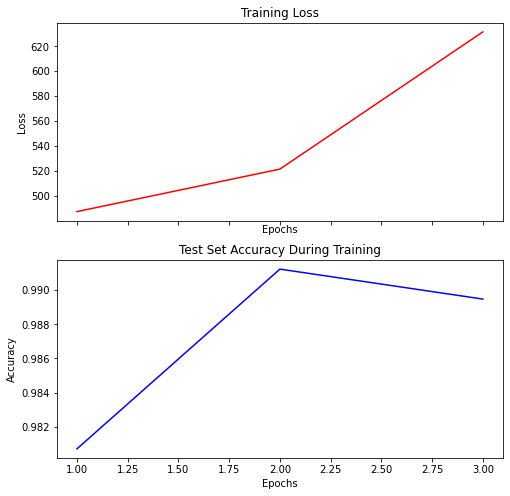

In [20]:
plot_loss_accuracy(losses, accuracies)

In [21]:
test_loader2 = get_data_imbalanced_loader(16, data_dir, "Test.csv")

Get data loader


INFO:__main__:Get data loader


In [22]:
device = torch.device('cuda')
test_preds = predict(bin_class_model, test_loader2, device)

In [23]:
test_preds = np.concatenate(test_preds)
(test_preds == 1).sum()

0

In [24]:
(test_preds == 0).sum()

570

### Shallow Classifier

In [25]:
accuracies = []
losses = []
shallow_bin_class = ShallowBinaryClassifier()

args = SimpleNamespace(
    batch_size=24,
    test_batch_size=16,
    epochs=10,
    lr=2e-5,
    seed=1,
    model=shallow_bin_class,
    log_interval =50,
    model_dir = "model/", 
    model_name="shallow_binary_classifier_3_24",
    data_dir="./data/", 
    num_gpus=1, 
    train_file = "Train.csv", 
    test_file="Test.csv"
)

shallow_bin_model = train_model(args)

Get data loader


INFO:__main__:Get data loader


Get data loader


INFO:__main__:Get data loader


Train Epoch: 1 [0/5087 (0%)] Loss: 0.683585


INFO:__main__:Train Epoch: 1 [0/5087 (0%)] Loss: 0.683585


Train Epoch: 1 [1200/5087 (24%)] Loss: 0.438087


INFO:__main__:Train Epoch: 1 [1200/5087 (24%)] Loss: 0.438087


Train Epoch: 1 [2400/5087 (47%)] Loss: 0.291687


INFO:__main__:Train Epoch: 1 [2400/5087 (47%)] Loss: 0.291687


Train Epoch: 1 [3600/5087 (71%)] Loss: 0.243027


INFO:__main__:Train Epoch: 1 [3600/5087 (71%)] Loss: 0.243027


Train Epoch: 1 [4800/5087 (94%)] Loss: 0.229000


INFO:__main__:Train Epoch: 1 [4800/5087 (94%)] Loss: 0.229000


Average training loss: 0.415192



INFO:__main__:Average training loss: 0.415192



Test set: Accuracy: 0.977193



INFO:__main__:Test set: Accuracy: 0.977193



Train Epoch: 2 [0/5087 (0%)] Loss: 0.370912


INFO:__main__:Train Epoch: 2 [0/5087 (0%)] Loss: 0.370912


Train Epoch: 2 [1200/5087 (24%)] Loss: 0.159844


INFO:__main__:Train Epoch: 2 [1200/5087 (24%)] Loss: 0.159844


Train Epoch: 2 [2400/5087 (47%)] Loss: 0.113627


INFO:__main__:Train Epoch: 2 [2400/5087 (47%)] Loss: 0.113627


Train Epoch: 2 [3600/5087 (71%)] Loss: 0.118578


INFO:__main__:Train Epoch: 2 [3600/5087 (71%)] Loss: 0.118578


Train Epoch: 2 [4800/5087 (94%)] Loss: 0.168668


INFO:__main__:Train Epoch: 2 [4800/5087 (94%)] Loss: 0.168668


Average training loss: 0.226640



INFO:__main__:Average training loss: 0.226640



Test set: Accuracy: 0.987719



INFO:__main__:Test set: Accuracy: 0.987719



Train Epoch: 3 [0/5087 (0%)] Loss: 0.174858


INFO:__main__:Train Epoch: 3 [0/5087 (0%)] Loss: 0.174858


Train Epoch: 3 [1200/5087 (24%)] Loss: 0.423392


INFO:__main__:Train Epoch: 3 [1200/5087 (24%)] Loss: 0.423392


Train Epoch: 3 [2400/5087 (47%)] Loss: 0.093536


INFO:__main__:Train Epoch: 3 [2400/5087 (47%)] Loss: 0.093536


Train Epoch: 3 [3600/5087 (71%)] Loss: 0.061781


INFO:__main__:Train Epoch: 3 [3600/5087 (71%)] Loss: 0.061781


Train Epoch: 3 [4800/5087 (94%)] Loss: 0.065287


INFO:__main__:Train Epoch: 3 [4800/5087 (94%)] Loss: 0.065287


Average training loss: 0.148524



INFO:__main__:Average training loss: 0.148524



Test set: Accuracy: 0.985965



INFO:__main__:Test set: Accuracy: 0.985965



Train Epoch: 4 [0/5087 (0%)] Loss: 0.168134


INFO:__main__:Train Epoch: 4 [0/5087 (0%)] Loss: 0.168134


Train Epoch: 4 [1200/5087 (24%)] Loss: 0.146985


INFO:__main__:Train Epoch: 4 [1200/5087 (24%)] Loss: 0.146985


Train Epoch: 4 [2400/5087 (47%)] Loss: 0.143186


INFO:__main__:Train Epoch: 4 [2400/5087 (47%)] Loss: 0.143186


Train Epoch: 4 [3600/5087 (71%)] Loss: 0.065138


INFO:__main__:Train Epoch: 4 [3600/5087 (71%)] Loss: 0.065138


Train Epoch: 4 [4800/5087 (94%)] Loss: 0.075303


INFO:__main__:Train Epoch: 4 [4800/5087 (94%)] Loss: 0.075303


Average training loss: 0.103999



INFO:__main__:Average training loss: 0.103999



Test set: Accuracy: 0.982456



INFO:__main__:Test set: Accuracy: 0.982456



Train Epoch: 5 [0/5087 (0%)] Loss: 0.062101


INFO:__main__:Train Epoch: 5 [0/5087 (0%)] Loss: 0.062101


Train Epoch: 5 [1200/5087 (24%)] Loss: 0.012165


INFO:__main__:Train Epoch: 5 [1200/5087 (24%)] Loss: 0.012165


Train Epoch: 5 [2400/5087 (47%)] Loss: 0.030983


INFO:__main__:Train Epoch: 5 [2400/5087 (47%)] Loss: 0.030983


Train Epoch: 5 [3600/5087 (71%)] Loss: 0.289048


INFO:__main__:Train Epoch: 5 [3600/5087 (71%)] Loss: 0.289048


Train Epoch: 5 [4800/5087 (94%)] Loss: 0.038962


INFO:__main__:Train Epoch: 5 [4800/5087 (94%)] Loss: 0.038962


Average training loss: 0.090459



INFO:__main__:Average training loss: 0.090459



Test set: Accuracy: 0.985965



INFO:__main__:Test set: Accuracy: 0.985965



Train Epoch: 6 [0/5087 (0%)] Loss: 0.182290


INFO:__main__:Train Epoch: 6 [0/5087 (0%)] Loss: 0.182290


Train Epoch: 6 [1200/5087 (24%)] Loss: 0.205584


INFO:__main__:Train Epoch: 6 [1200/5087 (24%)] Loss: 0.205584


Train Epoch: 6 [2400/5087 (47%)] Loss: 0.067701


INFO:__main__:Train Epoch: 6 [2400/5087 (47%)] Loss: 0.067701


Train Epoch: 6 [3600/5087 (71%)] Loss: 0.001710


INFO:__main__:Train Epoch: 6 [3600/5087 (71%)] Loss: 0.001710


Train Epoch: 6 [4800/5087 (94%)] Loss: 0.036774


INFO:__main__:Train Epoch: 6 [4800/5087 (94%)] Loss: 0.036774


Average training loss: 0.084083



INFO:__main__:Average training loss: 0.084083



Test set: Accuracy: 0.987719



INFO:__main__:Test set: Accuracy: 0.987719



Train Epoch: 7 [0/5087 (0%)] Loss: 0.070648


INFO:__main__:Train Epoch: 7 [0/5087 (0%)] Loss: 0.070648


Train Epoch: 7 [1200/5087 (24%)] Loss: 0.066494


INFO:__main__:Train Epoch: 7 [1200/5087 (24%)] Loss: 0.066494


Train Epoch: 7 [2400/5087 (47%)] Loss: 0.024576


INFO:__main__:Train Epoch: 7 [2400/5087 (47%)] Loss: 0.024576


Train Epoch: 7 [3600/5087 (71%)] Loss: 0.002418


INFO:__main__:Train Epoch: 7 [3600/5087 (71%)] Loss: 0.002418


Train Epoch: 7 [4800/5087 (94%)] Loss: 0.000443


INFO:__main__:Train Epoch: 7 [4800/5087 (94%)] Loss: 0.000443


Average training loss: 0.063789



INFO:__main__:Average training loss: 0.063789



Test set: Accuracy: 0.987719



INFO:__main__:Test set: Accuracy: 0.987719



Train Epoch: 8 [0/5087 (0%)] Loss: 0.058369


INFO:__main__:Train Epoch: 8 [0/5087 (0%)] Loss: 0.058369


Train Epoch: 8 [1200/5087 (24%)] Loss: 0.085471


INFO:__main__:Train Epoch: 8 [1200/5087 (24%)] Loss: 0.085471


Train Epoch: 8 [2400/5087 (47%)] Loss: 0.020032


INFO:__main__:Train Epoch: 8 [2400/5087 (47%)] Loss: 0.020032


Train Epoch: 8 [3600/5087 (71%)] Loss: 0.071811


INFO:__main__:Train Epoch: 8 [3600/5087 (71%)] Loss: 0.071811


Train Epoch: 8 [4800/5087 (94%)] Loss: 0.050995


INFO:__main__:Train Epoch: 8 [4800/5087 (94%)] Loss: 0.050995


Average training loss: 0.062582



INFO:__main__:Average training loss: 0.062582



Test set: Accuracy: 0.985965



INFO:__main__:Test set: Accuracy: 0.985965



Train Epoch: 9 [0/5087 (0%)] Loss: 0.050419


INFO:__main__:Train Epoch: 9 [0/5087 (0%)] Loss: 0.050419


Train Epoch: 9 [1200/5087 (24%)] Loss: 0.021476


INFO:__main__:Train Epoch: 9 [1200/5087 (24%)] Loss: 0.021476


Train Epoch: 9 [2400/5087 (47%)] Loss: 0.005131


INFO:__main__:Train Epoch: 9 [2400/5087 (47%)] Loss: 0.005131


Train Epoch: 9 [3600/5087 (71%)] Loss: 0.036941


INFO:__main__:Train Epoch: 9 [3600/5087 (71%)] Loss: 0.036941


Train Epoch: 9 [4800/5087 (94%)] Loss: 0.049003


INFO:__main__:Train Epoch: 9 [4800/5087 (94%)] Loss: 0.049003


Average training loss: 0.050216



INFO:__main__:Average training loss: 0.050216



Test set: Accuracy: 0.984211



INFO:__main__:Test set: Accuracy: 0.984211



Train Epoch: 10 [0/5087 (0%)] Loss: 0.036446


INFO:__main__:Train Epoch: 10 [0/5087 (0%)] Loss: 0.036446


Train Epoch: 10 [1200/5087 (24%)] Loss: 0.003480


INFO:__main__:Train Epoch: 10 [1200/5087 (24%)] Loss: 0.003480


Train Epoch: 10 [2400/5087 (47%)] Loss: 0.034338


INFO:__main__:Train Epoch: 10 [2400/5087 (47%)] Loss: 0.034338


Train Epoch: 10 [3600/5087 (71%)] Loss: 0.086180


INFO:__main__:Train Epoch: 10 [3600/5087 (71%)] Loss: 0.086180


Train Epoch: 10 [4800/5087 (94%)] Loss: 0.145718


INFO:__main__:Train Epoch: 10 [4800/5087 (94%)] Loss: 0.145718


Average training loss: 0.042418



INFO:__main__:Average training loss: 0.042418



Test set: Accuracy: 0.987719



INFO:__main__:Test set: Accuracy: 0.987719



Saving tuned model


INFO:__main__:Saving tuned model


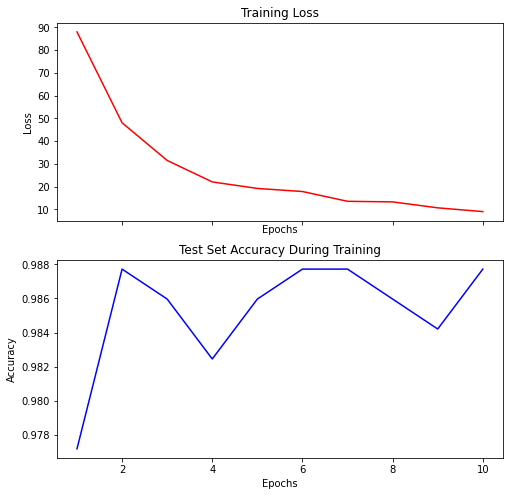

In [26]:
plot_loss_accuracy(losses, accuracies)

In [27]:
device = torch.device('cuda')
test_preds = predict(shallow_bin_model, test_loader2, device)

In [28]:
test_preds = np.concatenate(test_preds)
(test_preds == 1).sum()

3

In [29]:
(test_preds == 0).sum()

567

In [30]:
test(shallow_bin_model, test_loader2, device)

Test set: Accuracy: 0.478947



INFO:__main__:Test set: Accuracy: 0.478947



### 1D Convolutional Neural Network

In [77]:
accuracies = []
losses = []
cnn = CNN()
args = SimpleNamespace(
    batch_size=24,
    test_batch_size=16,
    epochs=10,
    lr=1e-5,
    seed=1,
    model=cnn,
    log_interval =50,
    model_dir = "model/", 
    model_name="cnn_10epochs_24batch",
    data_dir="./data/",
    train_loader=train_loader,
    test_loader=test_loader,
    num_gpus=1, 
    x_train_file = "x_train_scaled_filt.txt", 
    y_train_file="y_train.csv",
    x_test_file="x_test_scaled_filt.txt",
    y_test_file="y_test.csv"
)

cnn_model = train_model(args)

Train Epoch: 1 [0/8787 (0%)] Loss: 0.704801


INFO:__main__:Train Epoch: 1 [0/8787 (0%)] Loss: 0.704801


Train Epoch: 1 [1200/8787 (14%)] Loss: 0.550599


INFO:__main__:Train Epoch: 1 [1200/8787 (14%)] Loss: 0.550599


Train Epoch: 1 [2400/8787 (27%)] Loss: 0.436989


INFO:__main__:Train Epoch: 1 [2400/8787 (27%)] Loss: 0.436989


Train Epoch: 1 [3600/8787 (41%)] Loss: 0.273101


INFO:__main__:Train Epoch: 1 [3600/8787 (41%)] Loss: 0.273101


Train Epoch: 1 [4800/8787 (54%)] Loss: 0.348133


INFO:__main__:Train Epoch: 1 [4800/8787 (54%)] Loss: 0.348133


Train Epoch: 1 [6000/8787 (68%)] Loss: 0.501454


INFO:__main__:Train Epoch: 1 [6000/8787 (68%)] Loss: 0.501454


Train Epoch: 1 [7200/8787 (82%)] Loss: 0.065490


INFO:__main__:Train Epoch: 1 [7200/8787 (82%)] Loss: 0.065490


Train Epoch: 1 [8400/8787 (95%)] Loss: 0.280788


INFO:__main__:Train Epoch: 1 [8400/8787 (95%)] Loss: 0.280788


Average training loss: 0.381259



INFO:__main__:Average training loss: 0.381259



Test set: Accuracy: 0.982456



INFO:__main__:Test set: Accuracy: 0.982456



Train Epoch: 2 [0/8787 (0%)] Loss: 0.216395


INFO:__main__:Train Epoch: 2 [0/8787 (0%)] Loss: 0.216395


Train Epoch: 2 [1200/8787 (14%)] Loss: 0.405311


INFO:__main__:Train Epoch: 2 [1200/8787 (14%)] Loss: 0.405311


Train Epoch: 2 [2400/8787 (27%)] Loss: 0.433808


INFO:__main__:Train Epoch: 2 [2400/8787 (27%)] Loss: 0.433808


Train Epoch: 2 [3600/8787 (41%)] Loss: 0.292307


INFO:__main__:Train Epoch: 2 [3600/8787 (41%)] Loss: 0.292307


Train Epoch: 2 [4800/8787 (54%)] Loss: 0.253870


INFO:__main__:Train Epoch: 2 [4800/8787 (54%)] Loss: 0.253870


Train Epoch: 2 [6000/8787 (68%)] Loss: 0.002280


INFO:__main__:Train Epoch: 2 [6000/8787 (68%)] Loss: 0.002280


Train Epoch: 2 [7200/8787 (82%)] Loss: 0.260467


INFO:__main__:Train Epoch: 2 [7200/8787 (82%)] Loss: 0.260467


Train Epoch: 2 [8400/8787 (95%)] Loss: 0.002672


INFO:__main__:Train Epoch: 2 [8400/8787 (95%)] Loss: 0.002672


Average training loss: 0.190772



INFO:__main__:Average training loss: 0.190772



Test set: Accuracy: 0.982456



INFO:__main__:Test set: Accuracy: 0.982456



Train Epoch: 3 [0/8787 (0%)] Loss: 0.068454


INFO:__main__:Train Epoch: 3 [0/8787 (0%)] Loss: 0.068454


Train Epoch: 3 [1200/8787 (14%)] Loss: 0.004378


INFO:__main__:Train Epoch: 3 [1200/8787 (14%)] Loss: 0.004378


Train Epoch: 3 [2400/8787 (27%)] Loss: 0.337431


INFO:__main__:Train Epoch: 3 [2400/8787 (27%)] Loss: 0.337431


Train Epoch: 3 [3600/8787 (41%)] Loss: 0.036732


INFO:__main__:Train Epoch: 3 [3600/8787 (41%)] Loss: 0.036732


Train Epoch: 3 [4800/8787 (54%)] Loss: 0.012455


INFO:__main__:Train Epoch: 3 [4800/8787 (54%)] Loss: 0.012455


Train Epoch: 3 [6000/8787 (68%)] Loss: 0.046083


INFO:__main__:Train Epoch: 3 [6000/8787 (68%)] Loss: 0.046083


Train Epoch: 3 [7200/8787 (82%)] Loss: 0.390451


INFO:__main__:Train Epoch: 3 [7200/8787 (82%)] Loss: 0.390451


Train Epoch: 3 [8400/8787 (95%)] Loss: 0.237277


INFO:__main__:Train Epoch: 3 [8400/8787 (95%)] Loss: 0.237277


Average training loss: 0.146921



INFO:__main__:Average training loss: 0.146921



Test set: Accuracy: 0.984211



INFO:__main__:Test set: Accuracy: 0.984211



Train Epoch: 4 [0/8787 (0%)] Loss: 0.013988


INFO:__main__:Train Epoch: 4 [0/8787 (0%)] Loss: 0.013988


Train Epoch: 4 [1200/8787 (14%)] Loss: 0.009216


INFO:__main__:Train Epoch: 4 [1200/8787 (14%)] Loss: 0.009216


Train Epoch: 4 [2400/8787 (27%)] Loss: 0.362645


INFO:__main__:Train Epoch: 4 [2400/8787 (27%)] Loss: 0.362645


Train Epoch: 4 [3600/8787 (41%)] Loss: 0.242337


INFO:__main__:Train Epoch: 4 [3600/8787 (41%)] Loss: 0.242337


Train Epoch: 4 [4800/8787 (54%)] Loss: 0.010947


INFO:__main__:Train Epoch: 4 [4800/8787 (54%)] Loss: 0.010947


Train Epoch: 4 [6000/8787 (68%)] Loss: 0.003924


INFO:__main__:Train Epoch: 4 [6000/8787 (68%)] Loss: 0.003924


Train Epoch: 4 [7200/8787 (82%)] Loss: 0.369996


INFO:__main__:Train Epoch: 4 [7200/8787 (82%)] Loss: 0.369996


Train Epoch: 4 [8400/8787 (95%)] Loss: 0.000081


INFO:__main__:Train Epoch: 4 [8400/8787 (95%)] Loss: 0.000081


Average training loss: 0.112988



INFO:__main__:Average training loss: 0.112988



Test set: Accuracy: 0.968421



INFO:__main__:Test set: Accuracy: 0.968421



Train Epoch: 5 [0/8787 (0%)] Loss: 0.255359


INFO:__main__:Train Epoch: 5 [0/8787 (0%)] Loss: 0.255359


Train Epoch: 5 [1200/8787 (14%)] Loss: 0.001491


INFO:__main__:Train Epoch: 5 [1200/8787 (14%)] Loss: 0.001491


Train Epoch: 5 [2400/8787 (27%)] Loss: 0.024371


INFO:__main__:Train Epoch: 5 [2400/8787 (27%)] Loss: 0.024371


Train Epoch: 5 [3600/8787 (41%)] Loss: 0.002085


INFO:__main__:Train Epoch: 5 [3600/8787 (41%)] Loss: 0.002085


Train Epoch: 5 [4800/8787 (54%)] Loss: 0.009366


INFO:__main__:Train Epoch: 5 [4800/8787 (54%)] Loss: 0.009366


Train Epoch: 5 [6000/8787 (68%)] Loss: 0.004924


INFO:__main__:Train Epoch: 5 [6000/8787 (68%)] Loss: 0.004924


Train Epoch: 5 [7200/8787 (82%)] Loss: 0.003502


INFO:__main__:Train Epoch: 5 [7200/8787 (82%)] Loss: 0.003502


Train Epoch: 5 [8400/8787 (95%)] Loss: 0.078116


INFO:__main__:Train Epoch: 5 [8400/8787 (95%)] Loss: 0.078116


Average training loss: 0.098149



INFO:__main__:Average training loss: 0.098149



Test set: Accuracy: 0.980702



INFO:__main__:Test set: Accuracy: 0.980702



Train Epoch: 6 [0/8787 (0%)] Loss: 0.006884


INFO:__main__:Train Epoch: 6 [0/8787 (0%)] Loss: 0.006884


Train Epoch: 6 [1200/8787 (14%)] Loss: 0.314671


INFO:__main__:Train Epoch: 6 [1200/8787 (14%)] Loss: 0.314671


Train Epoch: 6 [2400/8787 (27%)] Loss: 0.002953


INFO:__main__:Train Epoch: 6 [2400/8787 (27%)] Loss: 0.002953


Train Epoch: 6 [3600/8787 (41%)] Loss: 0.000764


INFO:__main__:Train Epoch: 6 [3600/8787 (41%)] Loss: 0.000764


Train Epoch: 6 [4800/8787 (54%)] Loss: 0.006379


INFO:__main__:Train Epoch: 6 [4800/8787 (54%)] Loss: 0.006379


Train Epoch: 6 [6000/8787 (68%)] Loss: 0.001546


INFO:__main__:Train Epoch: 6 [6000/8787 (68%)] Loss: 0.001546


Train Epoch: 6 [7200/8787 (82%)] Loss: 0.000175


INFO:__main__:Train Epoch: 6 [7200/8787 (82%)] Loss: 0.000175


Train Epoch: 6 [8400/8787 (95%)] Loss: 0.004924


INFO:__main__:Train Epoch: 6 [8400/8787 (95%)] Loss: 0.004924


Average training loss: 0.079437



INFO:__main__:Average training loss: 0.079437



Test set: Accuracy: 0.980702



INFO:__main__:Test set: Accuracy: 0.980702



Train Epoch: 7 [0/8787 (0%)] Loss: 0.018520


INFO:__main__:Train Epoch: 7 [0/8787 (0%)] Loss: 0.018520


Train Epoch: 7 [1200/8787 (14%)] Loss: 0.114865


INFO:__main__:Train Epoch: 7 [1200/8787 (14%)] Loss: 0.114865


Train Epoch: 7 [2400/8787 (27%)] Loss: 0.135269


INFO:__main__:Train Epoch: 7 [2400/8787 (27%)] Loss: 0.135269


Train Epoch: 7 [3600/8787 (41%)] Loss: 0.019175


INFO:__main__:Train Epoch: 7 [3600/8787 (41%)] Loss: 0.019175


Train Epoch: 7 [4800/8787 (54%)] Loss: 0.002397


INFO:__main__:Train Epoch: 7 [4800/8787 (54%)] Loss: 0.002397


Train Epoch: 7 [6000/8787 (68%)] Loss: 0.001989


INFO:__main__:Train Epoch: 7 [6000/8787 (68%)] Loss: 0.001989


Train Epoch: 7 [7200/8787 (82%)] Loss: 0.236024


INFO:__main__:Train Epoch: 7 [7200/8787 (82%)] Loss: 0.236024


Train Epoch: 7 [8400/8787 (95%)] Loss: 0.000580


INFO:__main__:Train Epoch: 7 [8400/8787 (95%)] Loss: 0.000580


Average training loss: 0.070364



INFO:__main__:Average training loss: 0.070364



Test set: Accuracy: 0.982456



INFO:__main__:Test set: Accuracy: 0.982456



Train Epoch: 8 [0/8787 (0%)] Loss: 0.170087


INFO:__main__:Train Epoch: 8 [0/8787 (0%)] Loss: 0.170087


Train Epoch: 8 [1200/8787 (14%)] Loss: 0.000164


INFO:__main__:Train Epoch: 8 [1200/8787 (14%)] Loss: 0.000164


Train Epoch: 8 [2400/8787 (27%)] Loss: 0.003954


INFO:__main__:Train Epoch: 8 [2400/8787 (27%)] Loss: 0.003954


Train Epoch: 8 [3600/8787 (41%)] Loss: 0.000673


INFO:__main__:Train Epoch: 8 [3600/8787 (41%)] Loss: 0.000673


Train Epoch: 8 [4800/8787 (54%)] Loss: 0.123469


INFO:__main__:Train Epoch: 8 [4800/8787 (54%)] Loss: 0.123469


Train Epoch: 8 [6000/8787 (68%)] Loss: 0.423092


INFO:__main__:Train Epoch: 8 [6000/8787 (68%)] Loss: 0.423092


Train Epoch: 8 [7200/8787 (82%)] Loss: 0.003417


INFO:__main__:Train Epoch: 8 [7200/8787 (82%)] Loss: 0.003417


Train Epoch: 8 [8400/8787 (95%)] Loss: 0.001914


INFO:__main__:Train Epoch: 8 [8400/8787 (95%)] Loss: 0.001914


Average training loss: 0.063346



INFO:__main__:Average training loss: 0.063346



Test set: Accuracy: 0.987719



INFO:__main__:Test set: Accuracy: 0.987719



Train Epoch: 9 [0/8787 (0%)] Loss: 0.060300


INFO:__main__:Train Epoch: 9 [0/8787 (0%)] Loss: 0.060300


Train Epoch: 9 [1200/8787 (14%)] Loss: 0.279001


INFO:__main__:Train Epoch: 9 [1200/8787 (14%)] Loss: 0.279001


Train Epoch: 9 [2400/8787 (27%)] Loss: 0.032820


INFO:__main__:Train Epoch: 9 [2400/8787 (27%)] Loss: 0.032820


Train Epoch: 9 [3600/8787 (41%)] Loss: 0.001148


INFO:__main__:Train Epoch: 9 [3600/8787 (41%)] Loss: 0.001148


Train Epoch: 9 [4800/8787 (54%)] Loss: 0.193978


INFO:__main__:Train Epoch: 9 [4800/8787 (54%)] Loss: 0.193978


Train Epoch: 9 [6000/8787 (68%)] Loss: 0.290704


INFO:__main__:Train Epoch: 9 [6000/8787 (68%)] Loss: 0.290704


Train Epoch: 9 [7200/8787 (82%)] Loss: 0.014021


INFO:__main__:Train Epoch: 9 [7200/8787 (82%)] Loss: 0.014021


Train Epoch: 9 [8400/8787 (95%)] Loss: 0.004823


INFO:__main__:Train Epoch: 9 [8400/8787 (95%)] Loss: 0.004823


Average training loss: 0.063248



INFO:__main__:Average training loss: 0.063248



Test set: Accuracy: 0.963158



INFO:__main__:Test set: Accuracy: 0.963158



Train Epoch: 10 [0/8787 (0%)] Loss: 0.005929


INFO:__main__:Train Epoch: 10 [0/8787 (0%)] Loss: 0.005929


Train Epoch: 10 [1200/8787 (14%)] Loss: 0.284630


INFO:__main__:Train Epoch: 10 [1200/8787 (14%)] Loss: 0.284630


Train Epoch: 10 [2400/8787 (27%)] Loss: 0.019560


INFO:__main__:Train Epoch: 10 [2400/8787 (27%)] Loss: 0.019560


Train Epoch: 10 [3600/8787 (41%)] Loss: 0.001932


INFO:__main__:Train Epoch: 10 [3600/8787 (41%)] Loss: 0.001932


Train Epoch: 10 [4800/8787 (54%)] Loss: 0.003397


INFO:__main__:Train Epoch: 10 [4800/8787 (54%)] Loss: 0.003397


Train Epoch: 10 [6000/8787 (68%)] Loss: 0.262770


INFO:__main__:Train Epoch: 10 [6000/8787 (68%)] Loss: 0.262770


Train Epoch: 10 [7200/8787 (82%)] Loss: 0.156071


INFO:__main__:Train Epoch: 10 [7200/8787 (82%)] Loss: 0.156071


Train Epoch: 10 [8400/8787 (95%)] Loss: 0.003736


INFO:__main__:Train Epoch: 10 [8400/8787 (95%)] Loss: 0.003736


Average training loss: 0.055859



INFO:__main__:Average training loss: 0.055859



Test set: Accuracy: 0.970175



INFO:__main__:Test set: Accuracy: 0.970175



Saving tuned model


INFO:__main__:Saving tuned model


In [25]:
# test_loader = get_data_imbalanced_loader(16, "./data/", "x_test_scaled_filt.txt", "y_test.csv")

Get data loader


INFO:__main__:Get data loader


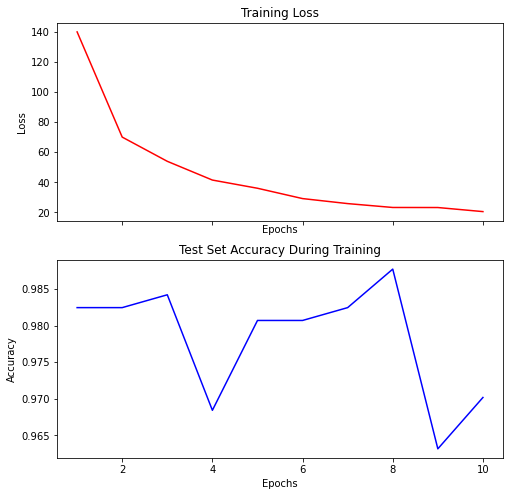

In [78]:
plot_loss_accuracy(losses, accuracies)

In [62]:
y_trues = []
for batch in test_loader:
    b_labels = batch[1].to(device) 
    label_ids = b_labels.to("cpu").numpy()
    y_trues.append(label_ids)

y_trues = np.concatenate(y_trues).ravel()

In [63]:
device = torch.device('cuda')
test_preds = predict(cnn_model, test_loader, device)

In [64]:
test_preds = np.concatenate(test_preds)
(test_preds == 1).sum()

534

In [65]:
(test_preds == 0).sum()

36

In [66]:
print(classification_report(y_trues, test_preds))

              precision    recall  f1-score   support

           0       1.00      0.06      0.12       565
           1       0.01      1.00      0.02         5

    accuracy                           0.07       570
   macro avg       0.50      0.53      0.07       570
weighted avg       0.99      0.07      0.12       570



In [99]:
predictions = []
predctions_proba = []
y_trues = []
with torch.no_grad(): 
    for i, batch in enumerate(test_loader): 
        b_input_ids = batch[0].to(device) 
        b_labels = batch[1].to(device)
        label_ids = b_labels.to("cpu").numpy()
        y_trues.append(label_ids)
        
        outputs = cnn_model(b_input_ids.float()) 
        preds = outputs.detach().cpu().numpy() 
        predctions_proba.append(preds)
        pred_flat = np.round(preds,0).flatten() 
        predictions.append(pred_flat)
    
y_trues = np.concatenate(y_trues).ravel()
predctions_proba = np.concatenate(predctions_proba).ravel()
predictions = np.concatenate(predictions)

In [100]:
(predictions == 1).sum()

14

In [101]:
(y_trues == 1).sum()

5

In [102]:
print(classification_report(y_trues, predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       565
           1       0.07      0.20      0.11         5

    accuracy                           0.97       570
   macro avg       0.53      0.59      0.55       570
weighted avg       0.98      0.97      0.98       570



In [103]:
roc_auc_score(y_trues, predctions_proba)

0.5585840707964602

In [89]:
test(cnn_model, test_loader, device)

Test set: Accuracy: 0.970175



INFO:__main__:Test set: Accuracy: 0.970175



### Deeper CNN 

In [83]:
losses = []
accuracies = []

cnn2 = CNN2()

args = SimpleNamespace(
    batch_size=24,
    test_batch_size=16,
    epochs=10,
    lr=1e-5,
    seed=1,
    model=cnn2,
    log_interval =50,
    model_dir = "model/", 
    model_name="cnn2_40epochs_32batch",
    data_dir="./data/", 
    num_gpus=1,
    train_loader=train_loader,
    test_loader=test_loader,
    x_train_file = "x_train_scaled_filt.txt", 
    y_train_file="y_train.csv",
    x_test_file="x_test_scaled_filt.txt",
    y_test_file="y_test.csv"
)

cnn_model2 = train_model(args)

Train Epoch: 1 [0/8787 (0%)] Loss: 0.686171


INFO:__main__:Train Epoch: 1 [0/8787 (0%)] Loss: 0.686171


Train Epoch: 1 [1200/8787 (14%)] Loss: 0.738668


INFO:__main__:Train Epoch: 1 [1200/8787 (14%)] Loss: 0.738668


Train Epoch: 1 [2400/8787 (27%)] Loss: 0.687500


INFO:__main__:Train Epoch: 1 [2400/8787 (27%)] Loss: 0.687500


Train Epoch: 1 [3600/8787 (41%)] Loss: 0.630225


INFO:__main__:Train Epoch: 1 [3600/8787 (41%)] Loss: 0.630225


Train Epoch: 1 [4800/8787 (54%)] Loss: 0.700130


INFO:__main__:Train Epoch: 1 [4800/8787 (54%)] Loss: 0.700130


Train Epoch: 1 [6000/8787 (68%)] Loss: 0.647689


INFO:__main__:Train Epoch: 1 [6000/8787 (68%)] Loss: 0.647689


Train Epoch: 1 [7200/8787 (82%)] Loss: 0.623323


INFO:__main__:Train Epoch: 1 [7200/8787 (82%)] Loss: 0.623323


Train Epoch: 1 [8400/8787 (95%)] Loss: 0.700492


INFO:__main__:Train Epoch: 1 [8400/8787 (95%)] Loss: 0.700492


Average training loss: 0.657768



INFO:__main__:Average training loss: 0.657768



Test set: Accuracy: 0.971930



INFO:__main__:Test set: Accuracy: 0.971930



Train Epoch: 2 [0/8787 (0%)] Loss: 0.677696


INFO:__main__:Train Epoch: 2 [0/8787 (0%)] Loss: 0.677696


Train Epoch: 2 [1200/8787 (14%)] Loss: 0.628324


INFO:__main__:Train Epoch: 2 [1200/8787 (14%)] Loss: 0.628324


Train Epoch: 2 [2400/8787 (27%)] Loss: 0.615800


INFO:__main__:Train Epoch: 2 [2400/8787 (27%)] Loss: 0.615800


Train Epoch: 2 [3600/8787 (41%)] Loss: 0.640282


INFO:__main__:Train Epoch: 2 [3600/8787 (41%)] Loss: 0.640282


Train Epoch: 2 [4800/8787 (54%)] Loss: 0.665704


INFO:__main__:Train Epoch: 2 [4800/8787 (54%)] Loss: 0.665704


Train Epoch: 2 [6000/8787 (68%)] Loss: 0.343775


INFO:__main__:Train Epoch: 2 [6000/8787 (68%)] Loss: 0.343775


Train Epoch: 2 [7200/8787 (82%)] Loss: 0.590609


INFO:__main__:Train Epoch: 2 [7200/8787 (82%)] Loss: 0.590609


Train Epoch: 2 [8400/8787 (95%)] Loss: 0.316423


INFO:__main__:Train Epoch: 2 [8400/8787 (95%)] Loss: 0.316423


Average training loss: 0.572775



INFO:__main__:Average training loss: 0.572775



Test set: Accuracy: 0.978947



INFO:__main__:Test set: Accuracy: 0.978947



Train Epoch: 3 [0/8787 (0%)] Loss: 0.454921


INFO:__main__:Train Epoch: 3 [0/8787 (0%)] Loss: 0.454921


Train Epoch: 3 [1200/8787 (14%)] Loss: 0.317761


INFO:__main__:Train Epoch: 3 [1200/8787 (14%)] Loss: 0.317761


Train Epoch: 3 [2400/8787 (27%)] Loss: 0.642076


INFO:__main__:Train Epoch: 3 [2400/8787 (27%)] Loss: 0.642076


Train Epoch: 3 [3600/8787 (41%)] Loss: 0.538085


INFO:__main__:Train Epoch: 3 [3600/8787 (41%)] Loss: 0.538085


Train Epoch: 3 [4800/8787 (54%)] Loss: 0.432803


INFO:__main__:Train Epoch: 3 [4800/8787 (54%)] Loss: 0.432803


Train Epoch: 3 [6000/8787 (68%)] Loss: 0.534441


INFO:__main__:Train Epoch: 3 [6000/8787 (68%)] Loss: 0.534441


Train Epoch: 3 [7200/8787 (82%)] Loss: 0.593258


INFO:__main__:Train Epoch: 3 [7200/8787 (82%)] Loss: 0.593258


Train Epoch: 3 [8400/8787 (95%)] Loss: 0.638633


INFO:__main__:Train Epoch: 3 [8400/8787 (95%)] Loss: 0.638633


Average training loss: 0.466627



INFO:__main__:Average training loss: 0.466627



Test set: Accuracy: 0.984211



INFO:__main__:Test set: Accuracy: 0.984211



Train Epoch: 4 [0/8787 (0%)] Loss: 0.291569


INFO:__main__:Train Epoch: 4 [0/8787 (0%)] Loss: 0.291569


Train Epoch: 4 [1200/8787 (14%)] Loss: 0.307638


INFO:__main__:Train Epoch: 4 [1200/8787 (14%)] Loss: 0.307638


Train Epoch: 4 [2400/8787 (27%)] Loss: 0.297462


INFO:__main__:Train Epoch: 4 [2400/8787 (27%)] Loss: 0.297462


Train Epoch: 4 [3600/8787 (41%)] Loss: 0.561446


INFO:__main__:Train Epoch: 4 [3600/8787 (41%)] Loss: 0.561446


Train Epoch: 4 [4800/8787 (54%)] Loss: 0.265587


INFO:__main__:Train Epoch: 4 [4800/8787 (54%)] Loss: 0.265587


Train Epoch: 4 [6000/8787 (68%)] Loss: 0.235761


INFO:__main__:Train Epoch: 4 [6000/8787 (68%)] Loss: 0.235761


Train Epoch: 4 [7200/8787 (82%)] Loss: 0.708106


INFO:__main__:Train Epoch: 4 [7200/8787 (82%)] Loss: 0.708106


Train Epoch: 4 [8400/8787 (95%)] Loss: 0.117847


INFO:__main__:Train Epoch: 4 [8400/8787 (95%)] Loss: 0.117847


Average training loss: 0.364214



INFO:__main__:Average training loss: 0.364214



Test set: Accuracy: 0.964912



INFO:__main__:Test set: Accuracy: 0.964912



Train Epoch: 5 [0/8787 (0%)] Loss: 0.310678


INFO:__main__:Train Epoch: 5 [0/8787 (0%)] Loss: 0.310678


Train Epoch: 5 [1200/8787 (14%)] Loss: 0.153436


INFO:__main__:Train Epoch: 5 [1200/8787 (14%)] Loss: 0.153436


Train Epoch: 5 [2400/8787 (27%)] Loss: 0.365122


INFO:__main__:Train Epoch: 5 [2400/8787 (27%)] Loss: 0.365122


Train Epoch: 5 [3600/8787 (41%)] Loss: 0.289975


INFO:__main__:Train Epoch: 5 [3600/8787 (41%)] Loss: 0.289975


Train Epoch: 5 [4800/8787 (54%)] Loss: 0.185139


INFO:__main__:Train Epoch: 5 [4800/8787 (54%)] Loss: 0.185139


Train Epoch: 5 [6000/8787 (68%)] Loss: 0.340690


INFO:__main__:Train Epoch: 5 [6000/8787 (68%)] Loss: 0.340690


Train Epoch: 5 [7200/8787 (82%)] Loss: 0.195245


INFO:__main__:Train Epoch: 5 [7200/8787 (82%)] Loss: 0.195245


Train Epoch: 5 [8400/8787 (95%)] Loss: 0.253699


INFO:__main__:Train Epoch: 5 [8400/8787 (95%)] Loss: 0.253699


Average training loss: 0.290680



INFO:__main__:Average training loss: 0.290680



Test set: Accuracy: 0.973684



INFO:__main__:Test set: Accuracy: 0.973684



Train Epoch: 6 [0/8787 (0%)] Loss: 0.203151


INFO:__main__:Train Epoch: 6 [0/8787 (0%)] Loss: 0.203151


Train Epoch: 6 [1200/8787 (14%)] Loss: 0.352070


INFO:__main__:Train Epoch: 6 [1200/8787 (14%)] Loss: 0.352070


Train Epoch: 6 [2400/8787 (27%)] Loss: 0.162196


INFO:__main__:Train Epoch: 6 [2400/8787 (27%)] Loss: 0.162196


Train Epoch: 6 [3600/8787 (41%)] Loss: 0.101690


INFO:__main__:Train Epoch: 6 [3600/8787 (41%)] Loss: 0.101690


Train Epoch: 6 [4800/8787 (54%)] Loss: 0.113308


INFO:__main__:Train Epoch: 6 [4800/8787 (54%)] Loss: 0.113308


Train Epoch: 6 [6000/8787 (68%)] Loss: 0.199412


INFO:__main__:Train Epoch: 6 [6000/8787 (68%)] Loss: 0.199412


Train Epoch: 6 [7200/8787 (82%)] Loss: 0.030787


INFO:__main__:Train Epoch: 6 [7200/8787 (82%)] Loss: 0.030787


Train Epoch: 6 [8400/8787 (95%)] Loss: 0.338907


INFO:__main__:Train Epoch: 6 [8400/8787 (95%)] Loss: 0.338907


Average training loss: 0.235610



INFO:__main__:Average training loss: 0.235610



Test set: Accuracy: 0.963158



INFO:__main__:Test set: Accuracy: 0.963158



Train Epoch: 7 [0/8787 (0%)] Loss: 0.153705


INFO:__main__:Train Epoch: 7 [0/8787 (0%)] Loss: 0.153705


Train Epoch: 7 [1200/8787 (14%)] Loss: 0.247551


INFO:__main__:Train Epoch: 7 [1200/8787 (14%)] Loss: 0.247551


Train Epoch: 7 [2400/8787 (27%)] Loss: 0.344712


INFO:__main__:Train Epoch: 7 [2400/8787 (27%)] Loss: 0.344712


Train Epoch: 7 [3600/8787 (41%)] Loss: 0.192369


INFO:__main__:Train Epoch: 7 [3600/8787 (41%)] Loss: 0.192369


Train Epoch: 7 [4800/8787 (54%)] Loss: 0.053664


INFO:__main__:Train Epoch: 7 [4800/8787 (54%)] Loss: 0.053664


Train Epoch: 7 [6000/8787 (68%)] Loss: 0.024540


INFO:__main__:Train Epoch: 7 [6000/8787 (68%)] Loss: 0.024540


Train Epoch: 7 [7200/8787 (82%)] Loss: 0.315531


INFO:__main__:Train Epoch: 7 [7200/8787 (82%)] Loss: 0.315531


Train Epoch: 7 [8400/8787 (95%)] Loss: 0.137606


INFO:__main__:Train Epoch: 7 [8400/8787 (95%)] Loss: 0.137606


Average training loss: 0.195453



INFO:__main__:Average training loss: 0.195453



Test set: Accuracy: 0.794737



INFO:__main__:Test set: Accuracy: 0.794737



Train Epoch: 8 [0/8787 (0%)] Loss: 0.126918


INFO:__main__:Train Epoch: 8 [0/8787 (0%)] Loss: 0.126918


Train Epoch: 8 [1200/8787 (14%)] Loss: 0.056318


INFO:__main__:Train Epoch: 8 [1200/8787 (14%)] Loss: 0.056318


Train Epoch: 8 [2400/8787 (27%)] Loss: 0.232945


INFO:__main__:Train Epoch: 8 [2400/8787 (27%)] Loss: 0.232945


Train Epoch: 8 [3600/8787 (41%)] Loss: 0.051863


INFO:__main__:Train Epoch: 8 [3600/8787 (41%)] Loss: 0.051863


Train Epoch: 8 [4800/8787 (54%)] Loss: 0.267315


INFO:__main__:Train Epoch: 8 [4800/8787 (54%)] Loss: 0.267315


Train Epoch: 8 [6000/8787 (68%)] Loss: 0.413391


INFO:__main__:Train Epoch: 8 [6000/8787 (68%)] Loss: 0.413391


Train Epoch: 8 [7200/8787 (82%)] Loss: 0.108148


INFO:__main__:Train Epoch: 8 [7200/8787 (82%)] Loss: 0.108148


Train Epoch: 8 [8400/8787 (95%)] Loss: 0.105209


INFO:__main__:Train Epoch: 8 [8400/8787 (95%)] Loss: 0.105209


Average training loss: 0.169490



INFO:__main__:Average training loss: 0.169490



Test set: Accuracy: 0.156140



INFO:__main__:Test set: Accuracy: 0.156140



Train Epoch: 9 [0/8787 (0%)] Loss: 0.162584


INFO:__main__:Train Epoch: 9 [0/8787 (0%)] Loss: 0.162584


Train Epoch: 9 [1200/8787 (14%)] Loss: 0.415014


INFO:__main__:Train Epoch: 9 [1200/8787 (14%)] Loss: 0.415014


Train Epoch: 9 [2400/8787 (27%)] Loss: 0.199250


INFO:__main__:Train Epoch: 9 [2400/8787 (27%)] Loss: 0.199250


Train Epoch: 9 [3600/8787 (41%)] Loss: 0.033220


INFO:__main__:Train Epoch: 9 [3600/8787 (41%)] Loss: 0.033220


Train Epoch: 9 [4800/8787 (54%)] Loss: 0.164794


INFO:__main__:Train Epoch: 9 [4800/8787 (54%)] Loss: 0.164794


Train Epoch: 9 [6000/8787 (68%)] Loss: 0.269188


INFO:__main__:Train Epoch: 9 [6000/8787 (68%)] Loss: 0.269188


Train Epoch: 9 [7200/8787 (82%)] Loss: 0.352215


INFO:__main__:Train Epoch: 9 [7200/8787 (82%)] Loss: 0.352215


Train Epoch: 9 [8400/8787 (95%)] Loss: 0.101051


INFO:__main__:Train Epoch: 9 [8400/8787 (95%)] Loss: 0.101051


Average training loss: 0.146626



INFO:__main__:Average training loss: 0.146626



Test set: Accuracy: 0.096491



INFO:__main__:Test set: Accuracy: 0.096491



Train Epoch: 10 [0/8787 (0%)] Loss: 0.107541


INFO:__main__:Train Epoch: 10 [0/8787 (0%)] Loss: 0.107541


Train Epoch: 10 [1200/8787 (14%)] Loss: 0.217387


INFO:__main__:Train Epoch: 10 [1200/8787 (14%)] Loss: 0.217387


Train Epoch: 10 [2400/8787 (27%)] Loss: 0.127663


INFO:__main__:Train Epoch: 10 [2400/8787 (27%)] Loss: 0.127663


Train Epoch: 10 [3600/8787 (41%)] Loss: 0.004384


INFO:__main__:Train Epoch: 10 [3600/8787 (41%)] Loss: 0.004384


Train Epoch: 10 [4800/8787 (54%)] Loss: 0.085758


INFO:__main__:Train Epoch: 10 [4800/8787 (54%)] Loss: 0.085758


Train Epoch: 10 [6000/8787 (68%)] Loss: 0.307321


INFO:__main__:Train Epoch: 10 [6000/8787 (68%)] Loss: 0.307321


Train Epoch: 10 [7200/8787 (82%)] Loss: 0.229889


INFO:__main__:Train Epoch: 10 [7200/8787 (82%)] Loss: 0.229889


Train Epoch: 10 [8400/8787 (95%)] Loss: 0.090529


INFO:__main__:Train Epoch: 10 [8400/8787 (95%)] Loss: 0.090529


Average training loss: 0.133748



INFO:__main__:Average training loss: 0.133748



Test set: Accuracy: 0.096491



INFO:__main__:Test set: Accuracy: 0.096491



Saving tuned model


INFO:__main__:Saving tuned model


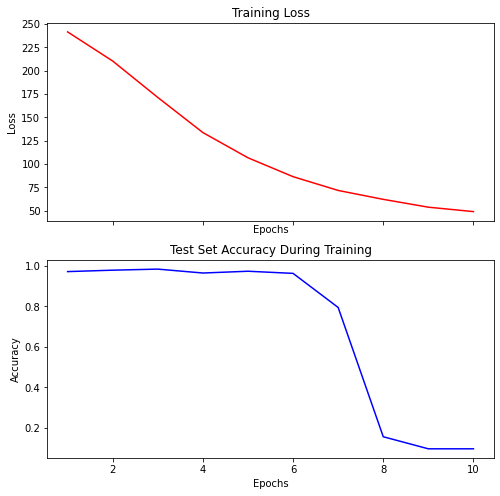

In [84]:
plot_loss_accuracy(losses, accuracies)

In [85]:
device = torch.device('cuda')
test_preds = predict(cnn_model2, test_loader, device)

In [94]:
predictions = []
predctions_proba = []
y_trues = []
with torch.no_grad(): 
    for i, batch in enumerate(test_loader): 
        b_input_ids = batch[0].to(device) 
        b_labels = batch[1].to(device)
        label_ids = b_labels.to("cpu").numpy()
        y_trues.append(label_ids)
        
        outputs = cnn_model2(b_input_ids.float()) 
        preds = outputs.detach().cpu().numpy() 
        predctions_proba.append(preds)
        pred_flat = np.round(preds,0).flatten() 
        predictions.append(pred_flat)
    
y_trues = np.concatenate(y_trues).ravel()
predctions_proba = np.concatenate(predctions_proba).ravel()
predictions = np.concatenate(predictions)

In [92]:
(predictions == 1).sum()

520

In [93]:
print(classification_report(y_trues, predictions))

              precision    recall  f1-score   support

           0       1.00      0.09      0.16       565
           1       0.01      1.00      0.02         5

    accuracy                           0.10       570
   macro avg       0.50      0.54      0.09       570
weighted avg       0.99      0.10      0.16       570



In [95]:
roc_auc_score(y_trues, predctions_proba)

0.6385840707964602

In [96]:
test(cnn_model2, test_loader, device)

Test set: Accuracy: 0.096491

Test set: Accuracy: 0.096491



INFO:__main__:Test set: Accuracy: 0.096491

